In [ ]:
%cd /content/drive/MyDrive/boda2

!pip install pytorch-lightning==1.9
!pip install cloudml-hypertune
!pip install dmslogo
!pip install biopython

from google.colab import output
output.clear()

In [ ]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

import pickle
from datetime import datetime
import scipy.stats as stats
import math

import hypertune
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import boda
from boda.common import constants, utils
from boda.common.utils import *

from src.main import unpack_artifact, model_fn
from src.pymeme import streme, parse_streme_output
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm
from boda.data import MPRA_DataModule

from boda.common.utils import batch2fasta

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import dmslogo
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d
%matplotlib inline

GPU available: Tesla V100-SXM2-16GB (1 count)


In [ ]:
# class constants():
#     def __init__(self):
#         self.STANDARD_NT = ['A','C','G','T']
#         self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
# constants = constants()

class utils():
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

# Load Malinois

In [ ]:
model_dir = './artifacts'
model = model_fn(model_dir)
model.cuda()
model.eval()
print()

Loaded model from 20211113_021200 in eval mode



# Load CODA library

In [ ]:
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)

row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
coda_library_df = boda2_df[row_filter_1 | (boda2_df['method'] == 'fsp') ].reset_index(drop=True)

coda_library_df['method_round'] = [row['method'] + '_' + str(row['round']) if row['round'] !=0 else row['method'] for _,row in coda_library_df.iterrows()]

cell_types = ['K562', 'HepG2', 'SKNSH']
cell_colors = ['#00A79D', '#FBB040', '#ED1C24']
cell_order = [x.lower() for x in cell_types]
method_order = ['DHS', 'gs', 'sa', 'al', 'fsp', 'fsp_1', 'fsp_2', 'fsp_3', 'fsp_4', 'fsp_5']
method_colors = ['#81BA37', '#5AE7AE', '#D972FF', '#8447FF'] + 6*['#FFB2E6']

## Load CODA contributions

In [ ]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')

contributions_dicts = {}
for cell_type in cell_types:
  contributions_dicts[cell_type] = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_contributions_{cell_type}.pt')

all_contributions = torch.stack([contributions_dicts[cell_type]['contributions'] for cell_type in cell_types], dim=0)
all_hyp_contributions = torch.stack([contributions_dicts[cell_type]['hyp_contributions'] for cell_type in cell_types], dim=0)

# Load core motifs

In [ ]:
tensor_motif_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_motif_tensors.pt")
motif_ids = list(tensor_motif_dict.keys())

In [ ]:
# custom_motif_names = ['GATA3', 'ELK4', 'FOSB::JUNB', 'HNF1B', 'HNF4A', 'CREB1', 'RELA', 'SP1', 'TEAD4',
#                       'TP53', 'IRF4', 'STAT1', 'FOXB1', 'NR5A1', 'DBP', 'SOX4', 'SREBF2', 'FOXI1',
#                       'TCF7L1', 'EHF', 'FOXJ2', '*NRF1', 'IRF3', 'NFATC2 x2', 'TYY1', 'NRF1', 'POU3F4', 'MEF2B',
#                       'GFI1B', 'ID4', '*NFIB', 'STREME_1', 'STREME_2', 'MEIS2', 'STREME_4', '*HSF1'
#                       ]

custom_motif_names = ['(GATA3) P0b', '(ELK4) P1', '(FOSB::JUNB) P2', '(HNF1B) P3', '(HNF4A) P4', '(CREB1) P5', '(RELA) P6', '(SP1) P7',
                      '(TEAD4) P10b', '(TP53) P12', '(IRF4) P14', '(STAT1) P15', '(FOXB1) P16', '(NR5A1) P21', '(DBP) P22', '(SOX4) P23b',
                      '(SREBF2) P26', '(FOXI1) P27b', '(TCF7L1) P30', '(EHF) P31', '(FOXJ2) P32b', '(NRF1*) P33', '(IRF3) P34',
                      '(NFATC2x2) P39', '(TYY1) P44', '(NRF1) P46', '(POU3F4) P51b', '(MEF2B) P57b',
                      '(GFI1B) N0', '(ID4) N5', '(NFIB*) N6', 'S1', 'S2', '(MEIS2) S3', 'S4', '(HSF1*) S5'
                      ]

In [ ]:
for temp_motif_id in ['pos_core_10b', 'pos_core_32b', 'pos_core_51b']:
    print(temp_motif_id)
    temp_ppm = tensor_motif_dict[temp_motif_id]
    temp_consensus = ''.join([constants.STANDARD_NT[j] for j in temp_ppm.argmax(dim=0).tolist()])
    temp_consensus_rev = ''.join((reversed([constants.DNA_COMPLEMENTS[nt] for nt in temp_consensus])))

    temp_consensus_df = coda_library_df[(coda_library_df['sequence'].str.contains(temp_consensus)) | (coda_library_df['sequence'].str.contains(temp_consensus_rev))]
    print(len(temp_consensus_df))

    # for seq in temp_consensus_df['sequence'].tolist():
    #     find_idx = seq.find(temp_consensus)
    #     if temp_consensus != seq[find_idx:find_idx + len(temp_consensus)]:
    #         print('Hey!')

    print()

pos_core_10b
318

pos_core_32b
191

pos_core_51b
124



In [ ]:
# from Bio import SeqIO
# from Bio.Seq import Seq
# from Bio.SeqRecord import SeqRecord

# def sample_sequences_from_ppm(ppm, num_sequences=500):
#     sequences = []

#     # Ensure the consensus sequence is included in generated sequences
#     consensus_sequence = "".join([np.random.choice(['A', 'C', 'G', 'T'], p=ppm[:, i]) for i in range(ppm.shape[1])])
#     sequences.append(SeqRecord(Seq(consensus_sequence), id="Consensus", description=""))

#     for _ in range(num_sequences - 1):  # Subtract 1 to account for the consensus sequence
#         sampled_sequence = "".join([np.random.choice(['A', 'C', 'G', 'T'], p=ppm[:, i]) for i in range(ppm.shape[1])])
#         seq_record = SeqRecord(Seq(sampled_sequence), id=f"Seq{_+1}", description="")
#         sequences.append(seq_record)

#     return sequences

# def write_fasta(sequences, filename="sequences.fasta"):
#     with open(filename, "w") as fasta_file:
#         SeqIO.write(sequences, fasta_file, "fasta")

# def write_meme_file(ppm, filename="motif.meme"):
#     with open(filename, "w") as meme_file:
#         meme_file.write("MEME version 4\n\n")
#         meme_file.write("ALPHABET= ACGT\n\n")
#         meme_file.write("strands: + -\n\n")
#         meme_file.write(f"MOTIF motif1\n")
#         meme_file.write(f"letter-probability matrix: alength= 4 w= {ppm.shape[1]} nsites= 1000\n")

#         for i in range(ppm.shape[1]):
#             for j in range(ppm.shape[0]):
#                 meme_file.write(f"{ppm[j, i]:.6f} ")
#             meme_file.write("\n")

# normalized_ppm = temp_ppm.numpy()
# generated_sequences = sample_sequences_from_ppm(normalized_ppm, num_sequences=100)

# write_fasta(generated_sequences, filename="/content/drive/MyDrive/generated_sequences.fasta")
# write_meme_file(normalized_ppm, filename="/content/drive/MyDrive/generated_motif.meme")

# Load core motif FIMO hits

In [ ]:
#--------- FIMO hits ----------------
#fimo_file_path = '/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo_core_modisco_streme_low_p.tsv'
# fimo_file_path = '/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo_core_modisco_streme_v2.tsv'

# full_fimo_df = pd.read_csv(fimo_file_path, sep='\t')
# full_fimo_df = full_fimo_df[:-3]

# full_fimo_df['start'] = full_fimo_df['start'].astype(int) - 1
# full_fimo_df['stop'] = full_fimo_df['stop'].astype(int)

# fimo_df = full_fimo_df[full_fimo_df['p-value'] < 0.1e-3].reset_index(drop=True)

#--------- Gradient-based motif hits ----------------
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t')
fimo_df['score'] = fimo_df['gradients_pearson']
fimo_df['p_value'] = fimo_df['gradients_pearson']

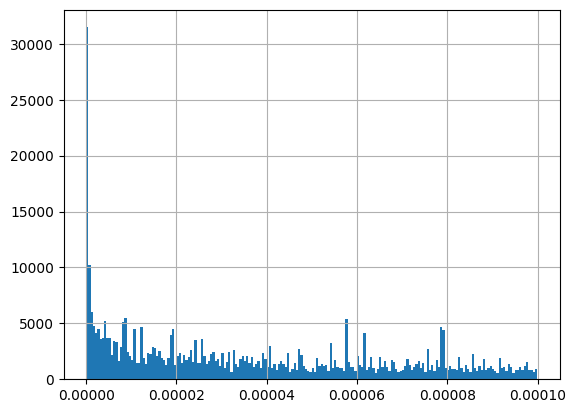

In [ ]:
full_fimo_df['p-value'].hist(bins=200)
plt.show()

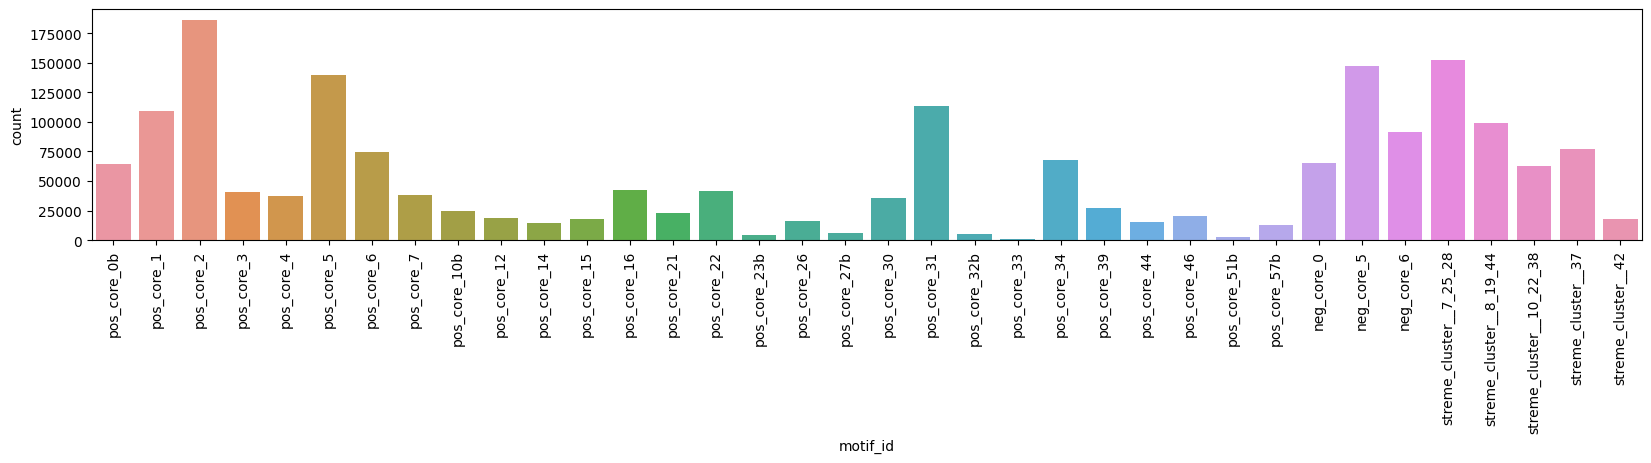

In [ ]:
plt.figure(figsize=(20,3))
sns.countplot(x="motif_id", data=fimo_df, order=motif_ids)
plt.xticks(rotation=90)
plt.show()

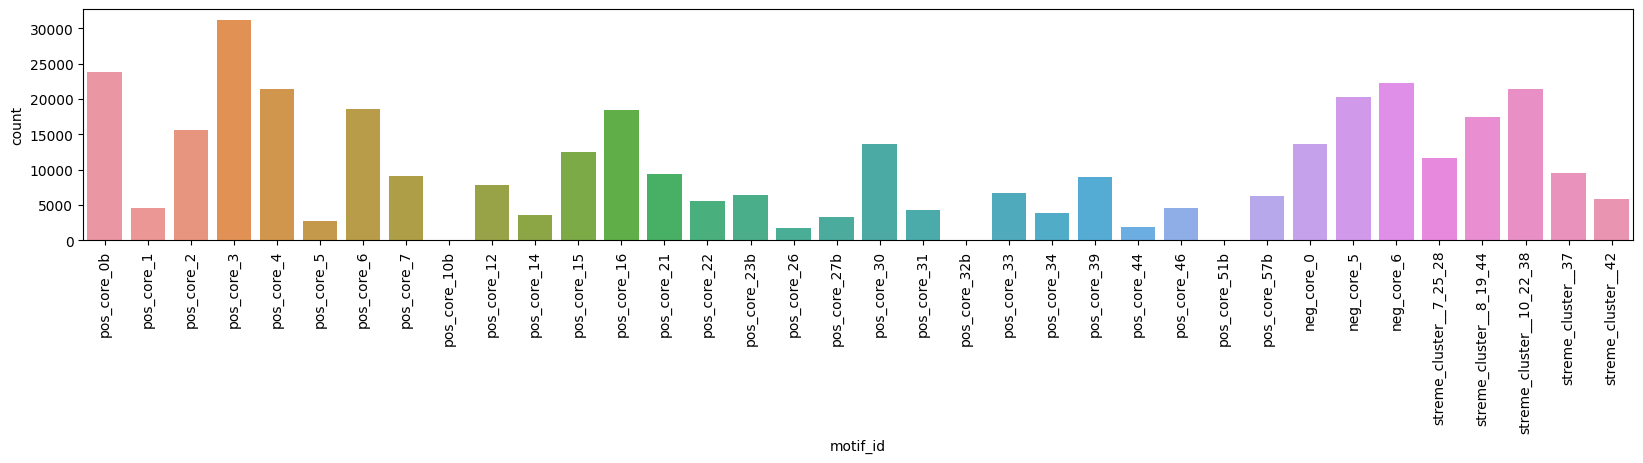

In [ ]:
plt.figure(figsize=(20,3))
sns.countplot(x="motif_id", data=fimo_df, order=motif_ids)
plt.xticks(rotation=90)
plt.show()

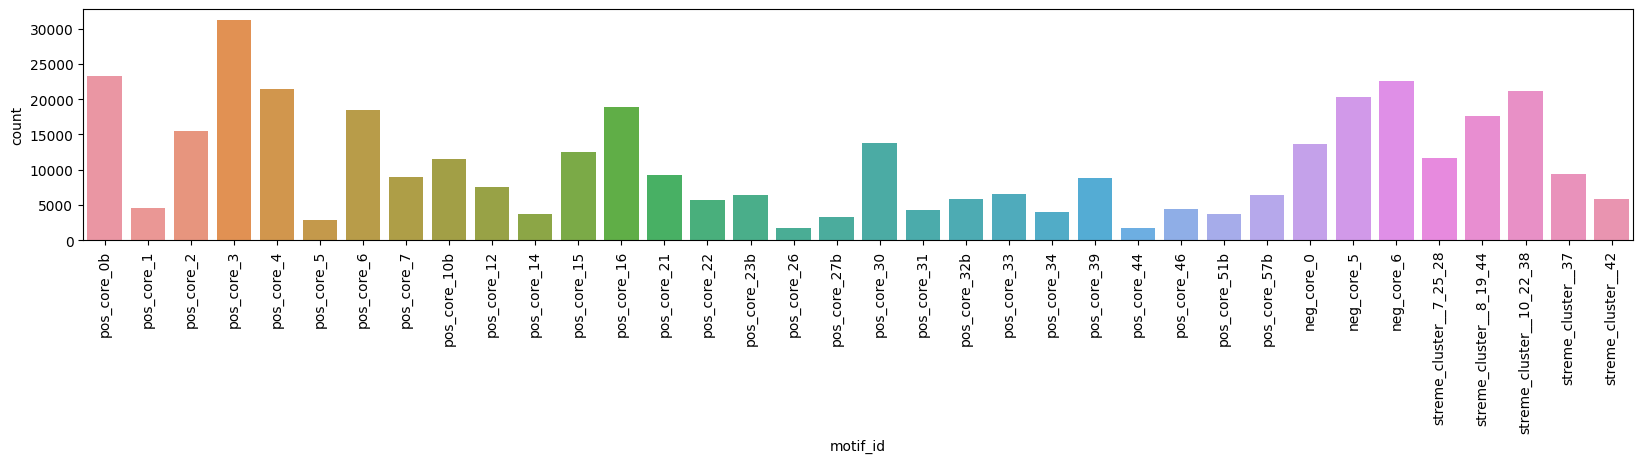

In [ ]:
plt.figure(figsize=(20,3))
sns.countplot(x="motif_id", data=fimo_df, order=motif_ids)
plt.xticks(rotation=90)
plt.show()

#Explore some motif hits on sequences

In [ ]:
seq_ids = ['20211212_75659__621411__391::fsp__sknsh__0', #N5 #BODA_SKNSH_Test1
                '20211206_24503__33072627__1223::al__hepg2__0', #L2

                '20211212_45907__313665__213::fsp__hepg2__0', #BODA_HEPG2_Test1
                '20211212_61436__944763__262::fsp__hepg2__0', #BODA_HEPG2_Test2
                '20211207_212124__46481152__2927::al__sknsh__0', #N3 #BODA_SKNSH_Test2
                '20211207_152258__777391__191::sa__sknsh__0', #N2
                '20211207_212124__46481152__3404::al__sknsh__0', #N4
                '20211206_24503__33072627__1816::al__hepg2__0', #L3
                '20211207_100944__255626__132::sa__hepg2__0', #L4

                '20211207_63610__124703__1517::sa__hepg2__0', #?
                '20211207_212124__46481152__3727::al__sknsh__0', #L?

                '20211212_55149__346635__38::fsp__hepg2__0',
                '20211212_52639__969454__182::fsp__hepg2__0',
                '20211212_12620__229779__1223::fsp__hepg2__0',
                '20211212_55149__346635__486::fsp__hepg2__0',
                '20211212_55149__346635__150::fsp__hepg2__0',
                '20211212_52639__969454__185::fsp__hepg2__0',
                '20211212_12620__229779__1181::fsp__hepg2__0',
                '20211212_12620__229779__56::fsp__hepg2__0',
                ]


# topic_idx = 8
# num_seqs_to_display = 10
# seq_idxs = np.where(over_means[:, topic_idx] > 0)[0]
# seq_ids = temp_df.iloc[seq_idxs]['ID'].tolist()
# topic_overmaxs = over_means[seq_idxs, topic_idx]
# idxs_to_display = np.flip(np.argsort(topic_overmaxs))[:num_seqs_to_display]
# seq_ids = [seq_ids[i] for i in idxs_to_display]

intersection_threshold = 200
cmap = plt.get_cmap('rainbow', len(motif_ids))

color_dict = dict(zip(2 * motif_ids, 2*[cmap(i) for i in range(len(motif_ids))]))

for order_idx, seq_id in enumerate(seq_ids):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    seq_scan_df = fimo_df[fimo_df['sequence_name'] == seq_id]
    seq_scan_df = seq_scan_df.sort_values('p-value', ascending=True).reset_index(drop=False)

    seq_contributions = all_contributions[:, seq_idx, ...]
    y_max = seq_contributions.max()

    find_motif_names  = []
    motifs_start_ends = []
    orientations      = []
    cover_set         = set()
    num_hits = len(seq_scan_df)
    for i in range(num_hits):
        hit_row = seq_scan_df.iloc[i]
        m_start, m_end = hit_row['start'], hit_row['stop']
        motif_range = set(np.arange(m_start, m_end))
        motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
        pos_contribution = motif_contributions.max()
        neg_contribution = motif_contributions.min()
        contribution_condition = True #(pos_contribution > 0.06) or (neg_contribution < -0.02)
        if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
            find_motif_names.append(hit_row['motif_id'])
            motifs_start_ends.append((m_start, m_end))
            orientations.append(hit_row['strand'])
            cover_set = cover_set | motif_range
    find_motif_short_names = [name + ' ' + strand for name, strand in zip(find_motif_names, orientations)]

    for i in range(0,3):
        matrix_plot = seq_contributions[i, ...]
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            heightscale=1.3, fontaspect=0.55)
        for idx, motif_name in enumerate(find_motif_names):
            try:
                color = color_dict[motif_name]
            except:
                color = color_dict[f'{motif_name}b']
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
            x = motifs_start_ends[idx][0]
            y = contrib_min_maxs[idx][1] + 0.05
            plt.text(x, y, text, fontsize=16, rotation=90)
        plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

# Disrupt motif instances

In [ ]:
seq_onehots = onehots_dict['onehots']

onehots = seq_onehots.clone()
#--- Predict ----
left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
        onehots,
        right_flank.repeat(onehots.shape[0], 1, 1)]
in_tensor = torch.cat( pieces, axis=-1)
temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())
#---
original_preds = torch.cat(preds, dim=0)

  0%|          | 0/74 [00:00<?, ?it/s]

In [ ]:
contribution_fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_full.tsv', sep='\t')
#contribution_fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_full_min_overlap.tsv', sep='\t')

fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t')
#fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike_min_overlap.tsv', sep='\t')

In [ ]:
fimo_df['score'] = fimo_df['gradients_pearson']
fimo_df['p_value'] = fimo_df['gradients_pearson']

In [ ]:
num_disruptions = 5
#fimo_df = full_fimo_df[full_fimo_df['p-value'] < 1e-4].reset_index(drop=True)                  #For FIMO
fimo_df = fimo_df[(fimo_df['start'] >= 0) & (fimo_df['stop'] <= 200)].reset_index(drop=True)    #For gradient-based matches

id_to_idx = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_disruption_dict = {}
all_motif_preds = {}
for motif_id in motif_ids:
    motif_df = fimo_df[fimo_df['motif_id'] == motif_id].reset_index(drop=True)
    if len(motif_df) == 0:
        print(f'No instances found for {motif_id}')
        pass
    else:
        #print(f'Retreiving sequences and positions to disrupt {motif_id}')
        motif_df['seq_idx'] = [id_to_idx[id] for id in motif_df['sequence_name'].tolist()]
        motif_df.sort_values('seq_idx', inplace=True)

        motif_ppm = tensor_motif_dict[motif_id]
        motif_pwm = ppm_to_pwm(motif_ppm)
        motif_icm = ppm_to_IC(motif_ppm)
        #motif_max_score = max(motif_pwm.max(dim=0).values.sum().item(), motif_df['score'].max())       #For FIMO
        motif_max_score = motif_df['score'].max()                                                       #For gradient-based matches

        matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.4,
                        axisfontscale=0.6, heightscale=0.4)
        plt.xlabel('')
        plt.ylabel('')
        plt.yticks([0,1,2])
        plt.title(motif_id)
        plt.show()

        motif_df['presence_share'] = motif_df['score'] / motif_max_score
        motif_df['interval'] = motif_df.apply(lambda row: np.arange(row['start'], row['stop']), axis=1)

        grouped = motif_df.groupby('seq_idx')

        motif_seq_idxs = list(grouped.groups.keys())
        motif_seq_positions = [np.unique(np.concatenate(group['interval'].values)) for _, group in grouped ]
        motif_presences = grouped['presence_share'].sum().tolist()
        seq_motif_hits = grouped.size().tolist()

        all_motif_disruption_dict[motif_id] = [motif_seq_idxs, motif_seq_positions, motif_presences, seq_motif_hits]

        motif_disrupted_preds = []
        for n in range(num_disruptions):
            #print(f'Disruption {n + 1}/{num_disruptions}...')
            motif_disrupted_seqs = []
            for seq_idx, seq_positions in zip(motif_seq_idxs, motif_seq_positions):
                motif_disrupted_seq = seq_onehots[seq_idx, ...]
                random_tokens = torch.randint(0, 4, (len(seq_positions),))
                random_onehot = torch.zeros(4, len(seq_positions))
                random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
                motif_disrupted_seq[..., seq_positions] = random_onehot
                motif_disrupted_seqs.append(motif_disrupted_seq)
            motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

            #print(f'Prediction {n + 1}/{num_disruptions}...')
            onehots = motif_disrupted_seqs.clone()
            #--- Predict ----
            left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
            right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
            pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
                    onehots,
                    right_flank.repeat(onehots.shape[0], 1, 1)]
            in_tensor = torch.cat( pieces, axis=-1)
            temp_dataset = TensorDataset(in_tensor)
            temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
            preds = []
            for local_batch in temp_dataloader:
                preds.append(model(local_batch[0].cuda()).detach().cpu())
            #---
            preds = torch.cat(preds, dim=0)
            motif_disrupted_preds.append(preds)

        motif_disrupted_preds = torch.stack(motif_disrupted_preds, dim=0).mean(dim=0)
        motif_original_preds = original_preds[motif_seq_idxs, ...]
        motif_disruption_skews = motif_disrupted_preds - motif_original_preds

        all_motif_preds[motif_id] = [motif_original_preds, motif_disrupted_preds, motif_disruption_skews]

        sorting = np.argsort(motif_presences)
        sorted_presences = np.sort(motif_presences)

        # plt.figure(figsize=(5,3))
        # for i in range(3):
        #     y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=5)
        #     plt.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
        # plt.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        # plt.xlabel('Motif presence')
        # plt.ylabel('Motif disruption effect (l2fc)')
        # plt.title(motif_id)
        # plt.show()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'height_ratios': [3, 1]})
        xtick_positions = np.arange(0, np.ceil(max(sorted_presences)))
        for i in range(3):
            # y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=3)
            # ax1.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
            ax1.scatter(sorted_presences, motif_disruption_skews[sorting, i].numpy(), color=cell_colors[i], alpha=0.5, marker='.', s=5)
        ax1.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        ax1.set_xlabel('Motif presence')
        ax1.set_ylabel('Motif disruption effect (l2fc)')
        ax1.set_title(motif_id)
        hist, bin_edges, _ = ax2.hist(sorted_presences, bins=200, color='skyblue', alpha=1)
        ax2.set_xlabel('Motif presence')
        ax2.set_ylabel('Frequency')
        ax1.set_xlim(0, 1)
        ax2.set_xlim(0, 1)
        ax1.set_xticks(xtick_positions)
        ax2.set_xticks(xtick_positions)
        plt.tight_layout()
        plt.show()
    print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
num_disruptions = 5
#fimo_df = full_fimo_df[full_fimo_df['p-value'] < 1e-4].reset_index(drop=True)

id_to_idx = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_disruption_dict = {}
all_motif_preds = {}
for motif_id in motif_ids:
    motif_df = fimo_df[fimo_df['motif_id'] == motif_id].reset_index(drop=True)
    if len(motif_df) == 0:
        print(f'No instances found for {motif_id}')
        pass
    else:
        #print(f'Retreiving sequences and positions to disrupt {motif_id}')
        motif_df['seq_idx'] = [id_to_idx[id] for id in motif_df['sequence_name'].tolist()]
        motif_df.sort_values('seq_idx', inplace=True)

        motif_ppm = tensor_motif_dict[motif_id]
        motif_pwm = ppm_to_pwm(motif_ppm)
        motif_icm = ppm_to_IC(motif_ppm)
        #motif_max_score = max(motif_pwm.max(dim=0).values.sum().item(), motif_df['score'].max())       #For FIMO
        motif_max_score = motif_df['score'].max()                                                       #For gradient-based matches

        matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.4,
                        axisfontscale=0.6, heightscale=0.4)
        plt.xlabel('')
        plt.ylabel('')
        plt.yticks([0,1,2])
        plt.title(motif_id)
        plt.show()
        print()

        motif_df['presence_share'] = motif_df['score'] / motif_max_score
        motif_df['interval'] = motif_df.apply(lambda row: np.arange(row['start'], row['stop']), axis=1)

        grouped = motif_df.groupby('seq_idx')

        motif_seq_idxs = list(grouped.groups.keys())
        motif_seq_positions = [np.unique(np.concatenate(group['interval'].values)) for _, group in grouped ]
        motif_presences = grouped['presence_share'].sum().tolist()
        seq_motif_hits = grouped.size().tolist()

        all_motif_disruption_dict[motif_id] = [motif_seq_idxs, motif_seq_positions, motif_presences, seq_motif_hits]

        motif_disrupted_preds = []
        for n in range(num_disruptions):
            #print(f'Disruption {n + 1}/{num_disruptions}...')
            motif_disrupted_seqs = []
            for seq_idx, seq_positions in zip(motif_seq_idxs, motif_seq_positions):
                motif_disrupted_seq = seq_onehots[seq_idx, ...]
                random_tokens = torch.randint(0, 4, (len(seq_positions),))
                random_onehot = torch.zeros(4, len(seq_positions))
                random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
                motif_disrupted_seq[..., seq_positions] = random_onehot
                motif_disrupted_seqs.append(motif_disrupted_seq)
            motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

            #print(f'Prediction {n + 1}/{num_disruptions}...')
            onehots = motif_disrupted_seqs.clone()
            #--- Predict ----
            left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
            right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
            pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
                    onehots,
                    right_flank.repeat(onehots.shape[0], 1, 1)]
            in_tensor = torch.cat( pieces, axis=-1)
            temp_dataset = TensorDataset(in_tensor)
            temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
            preds = []
            for local_batch in temp_dataloader:
                preds.append(model(local_batch[0].cuda()).detach().cpu())
            #---
            preds = torch.cat(preds, dim=0)
            motif_disrupted_preds.append(preds)

        motif_disrupted_preds = torch.stack(motif_disrupted_preds, dim=0).mean(dim=0)
        motif_original_preds = original_preds[motif_seq_idxs, ...]
        motif_disruption_skews = motif_disrupted_preds - motif_original_preds

        all_motif_preds[motif_id] = [motif_original_preds, motif_disrupted_preds, motif_disruption_skews]

        sorting = np.argsort(motif_presences)
        sorted_presences = np.sort(motif_presences)

        # plt.figure(figsize=(5,3))
        # for i in range(3):
        #     y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=5)
        #     plt.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
        # plt.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        # plt.xlabel('Motif presence')
        # plt.ylabel('Motif disruption effect (l2fc)')
        # plt.title(motif_id)
        # plt.show()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'height_ratios': [3, 1]})
        xtick_positions = np.arange(0, np.ceil(max(sorted_presences)))
        for i in range(3):
            y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=3)
            ax1.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
            #ax1.scatter(sorted_presences, motif_disruption_skews[sorting, i].numpy(), color=cell_colors[i], alpha=0.5, marker='.', s=5)
        ax1.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        ax1.set_xlabel('Motif presence')
        ax1.set_ylabel('Motif disruption effect (l2fc)')
        ax1.set_title(motif_id)
        hist, bin_edges, _ = ax2.hist(sorted_presences, bins=200, color='skyblue', alpha=1)
        ax2.set_xlabel('Motif presence')
        ax2.set_ylabel('Frequency')
        ax1.set_xlim(0, 1)
        ax2.set_xlim(0, 1)
        ax1.set_xticks(xtick_positions)
        ax2.set_xticks(xtick_positions)
        plt.tight_layout()
        plt.show()
        print()

        motif_hit_df = coda_library_df.iloc[motif_seq_idxs].reset_index(drop=True)

        plot_df = pd.DataFrame(motif_hit_df['target_cell'].value_counts())
        plot_df = plot_df.reindex(cell_order)

        plot_df_2 = pd.DataFrame(motif_hit_df['method_round'].value_counts())
        plot_df_2 = plot_df_2.reindex(method_order)

        plot_df.plot(kind='pie', y='target_cell', figsize=(2,2), legend=False, colors=cell_colors, fontsize=8)
        plt.ylabel('')
        plt.title('Target deployment', fontsize=10)
        plt.show()

        plot_df_2.plot(kind='pie', y='method_round', figsize=(2,2), legend=False, colors=method_colors, fontsize=8)
        plt.ylabel('')
        plt.title('Origin method', fontsize=10)
        plt.show()

    print()
    print()
    print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
num_disruptions = 5
fimo_df = full_fimo_df[full_fimo_df['p-value'] < 1e-4].reset_index(drop=True)

id_to_idx = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_disruption_dict = {}
all_motif_preds = {}
for motif_id in motif_ids:
    motif_df = fimo_df[fimo_df['motif_id'] == motif_id].reset_index(drop=True)
    if len(motif_df) == 0:
        print(f'No instances found for {motif_id}')
        pass
    else:
        #print(f'Retreiving sequences and positions to disrupt {motif_id}')
        motif_df['seq_idx'] = [id_to_idx[id] for id in motif_df['sequence_name'].tolist()]
        motif_df.sort_values('seq_idx', inplace=True)

        motif_ppm = tensor_motif_dict[motif_id]
        motif_pwm = ppm_to_pwm(motif_ppm)
        motif_icm = ppm_to_IC(motif_ppm)
        motif_max_score = max(motif_pwm.max(dim=0).values.sum().item(), motif_df['score'].max())

        matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.4,
                        axisfontscale=0.6, heightscale=0.4)
        plt.xlabel('')
        plt.ylabel('')
        plt.yticks([0,1,2])
        plt.title(motif_id)
        plt.show()
        print()

        motif_df['presence_share'] = motif_df['score'] / motif_max_score
        motif_df['interval'] = motif_df.apply(lambda row: np.arange(row['start'], row['stop']), axis=1)

        grouped = motif_df.groupby('seq_idx')

        motif_seq_idxs = list(grouped.groups.keys())
        motif_seq_positions = [np.unique(np.concatenate(group['interval'].values)) for _, group in grouped ]
        motif_presences = grouped['presence_share'].sum().tolist()
        seq_motif_hits = grouped.size().tolist()

        all_motif_disruption_dict[motif_id] = [motif_seq_idxs, motif_seq_positions, motif_presences, seq_motif_hits]

        motif_disrupted_preds = []
        for n in range(num_disruptions):
            #print(f'Disruption {n + 1}/{num_disruptions}...')
            motif_disrupted_seqs = []
            for seq_idx, seq_positions in zip(motif_seq_idxs, motif_seq_positions):
                motif_disrupted_seq = seq_onehots[seq_idx, ...]
                random_tokens = torch.randint(0, 4, (len(seq_positions),))
                random_onehot = torch.zeros(4, len(seq_positions))
                random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
                motif_disrupted_seq[..., seq_positions] = random_onehot
                motif_disrupted_seqs.append(motif_disrupted_seq)
            motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

            #print(f'Prediction {n + 1}/{num_disruptions}...')
            onehots = motif_disrupted_seqs.clone()
            #--- Predict ----
            left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
            right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
            pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
                    onehots,
                    right_flank.repeat(onehots.shape[0], 1, 1)]
            in_tensor = torch.cat( pieces, axis=-1)
            temp_dataset = TensorDataset(in_tensor)
            temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
            preds = []
            for local_batch in temp_dataloader:
                preds.append(model(local_batch[0].cuda()).detach().cpu())
            #---
            preds = torch.cat(preds, dim=0)
            motif_disrupted_preds.append(preds)

        motif_disrupted_preds = torch.stack(motif_disrupted_preds, dim=0).mean(dim=0)
        motif_original_preds = original_preds[motif_seq_idxs, ...]
        motif_disruption_skews = motif_disrupted_preds - motif_original_preds

        all_motif_preds[motif_id] = [motif_original_preds, motif_disrupted_preds, motif_disruption_skews]

        sorting = np.argsort(motif_presences)
        sorted_presences = np.sort(motif_presences)

        # plt.figure(figsize=(5,3))
        # for i in range(3):
        #     y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=5)
        #     plt.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
        # plt.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        # plt.xlabel('Motif presence')
        # plt.ylabel('Motif disruption effect (l2fc)')
        # plt.title(motif_id)
        # plt.show()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'height_ratios': [3, 1]})
        xtick_positions = np.arange(0, np.ceil(max(sorted_presences)))
        for i in range(3):
            y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=3)
            ax1.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
            #ax1.scatter(sorted_presences, motif_disruption_skews[sorting, i].numpy(), color=cell_colors[i], alpha=0.5, marker='.', s=5)
        ax1.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        ax1.set_xlabel('Motif presence')
        ax1.set_ylabel('Motif disruption effect (l2fc)')
        ax1.set_title(motif_id)
        hist, bin_edges, _ = ax2.hist(sorted_presences, bins=200, color='skyblue', alpha=1)
        ax2.set_xlabel('Motif presence')
        ax2.set_ylabel('Frequency')
        ax1.set_xlim(0, 1)
        ax2.set_xlim(0, 1)
        ax1.set_xticks(xtick_positions)
        ax2.set_xticks(xtick_positions)
        plt.tight_layout()
        plt.show()
        print()

        motif_hit_df = coda_library_df.iloc[motif_seq_idxs].reset_index(drop=True)

        plot_df = pd.DataFrame(motif_hit_df['target_cell'].value_counts())
        plot_df = plot_df.reindex(cell_order)

        plot_df_2 = pd.DataFrame(motif_hit_df['method_round'].value_counts())
        plot_df_2 = plot_df_2.reindex(method_order)

        plot_df.plot(kind='pie', y='target_cell', figsize=(2,2), legend=False, colors=cell_colors, fontsize=8)
        plt.ylabel('')
        plt.title('Target deployment', fontsize=10)
        plt.show()

        plot_df_2.plot(kind='pie', y='method_round', figsize=(2,2), legend=False, colors=method_colors, fontsize=8)
        plt.ylabel('')
        plt.title('Origin method', fontsize=10)
        plt.show()

    print()
    print()
    print()

Output hidden; open in https://colab.research.google.com to view.

# Disrupting STREME motifs

In [ ]:
seq_onehots = onehots_dict['onehots']

onehots = seq_onehots.clone()
#--- Predict ----
left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
        onehots,
        right_flank.repeat(onehots.shape[0], 1, 1)]
in_tensor = torch.cat( pieces, axis=-1)
temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())
#---
original_preds = torch.cat(preds, dim=0)

  0%|          | 0/74 [00:00<?, ?it/s]

In [ ]:
#--- STREME processed
file_path = "/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/STREME_min8_TFs_merge.txt"
boda2_streme_tfs_logos = pd.read_csv(file_path, sep=' ', low_memory=False)

df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for df_array_column in tqdm(df_array_columns):
    boda2_streme_tfs_logos[df_array_column] = boda2_streme_tfs_logos.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

motif_ids = boda2_streme_tfs_logos['name'].tolist()
tensor_motif_dict = dict(zip(motif_ids, [torch.tensor(ppm) for ppm in boda2_streme_tfs_logos['pwm'].tolist()]))

motif_id_to_short_name = dict(zip(motif_ids, boda2_streme_tfs_logos['ultimate_id'].tolist()))

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
full_fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo_min8.tsv', sep='\t')
full_fimo_df = full_fimo_df[:-3]

full_fimo_df['start'] = full_fimo_df['start'].astype(int) - 1
full_fimo_df['stop'] = full_fimo_df['stop'].astype(int)

full_fimo_df = full_fimo_df[full_fimo_df['sequence_name'].isin(onehots_dict['IDs'])].reset_index(drop=True)
fimo_df = full_fimo_df[full_fimo_df['p-value'] < 1e-4].reset_index(drop=True)

In [ ]:
num_disruptions = 5
fimo_df = full_fimo_df[full_fimo_df['p-value'] < 1e-4].reset_index(drop=True)

id_to_idx = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_disruption_dict = {}
all_motif_preds = {}
for motif_id in motif_ids:
    motif_df = fimo_df[fimo_df['motif_id'] == motif_id].reset_index(drop=True)
    if len(motif_df) == 0:
        print(f'No instances found for {motif_id}')
        pass
    else:
        #print(f'Retreiving sequences and positions to disrupt {motif_id}')
        motif_df['seq_idx'] = [id_to_idx[id] for id in motif_df['sequence_name'].tolist()]
        motif_df.sort_values('seq_idx', inplace=True)

        motif_ppm = tensor_motif_dict[motif_id]
        motif_pwm = ppm_to_pwm(motif_ppm)
        motif_icm = ppm_to_IC(motif_ppm)
        motif_max_score = max(motif_pwm.max(dim=0).values.sum().item(), motif_df['score'].max())

        matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.4,
                        axisfontscale=0.6, heightscale=0.4)
        plt.xlabel('')
        plt.ylabel('')
        plt.yticks([0,1,2])
        plt.title(motif_id_to_short_name[motif_id])
        plt.show()

        motif_df['presence_share'] = motif_df['score'] / motif_max_score
        motif_df['interval'] = motif_df.apply(lambda row: np.arange(row['start'], row['stop']), axis=1)

        grouped = motif_df.groupby('seq_idx')

        motif_seq_idxs = list(grouped.groups.keys())
        motif_seq_positions = [np.unique(np.concatenate(group['interval'].values)) for _, group in grouped ]
        motif_presences = grouped['presence_share'].sum().tolist()
        seq_motif_hits = grouped.size().tolist()

        all_motif_disruption_dict[motif_id] = [motif_seq_idxs, motif_seq_positions, motif_presences, seq_motif_hits]

        motif_disrupted_preds = []
        for n in range(num_disruptions):
            #print(f'Disruption {n + 1}/{num_disruptions}...')
            motif_disrupted_seqs = []
            for seq_idx, seq_positions in zip(motif_seq_idxs, motif_seq_positions):
                motif_disrupted_seq = seq_onehots[seq_idx, ...]
                random_tokens = torch.randint(0, 4, (len(seq_positions),))
                random_onehot = torch.zeros(4, len(seq_positions))
                random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
                motif_disrupted_seq[..., seq_positions] = random_onehot
                motif_disrupted_seqs.append(motif_disrupted_seq)
            motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

            #print(f'Prediction {n + 1}/{num_disruptions}...')
            onehots = motif_disrupted_seqs.clone()
            #--- Predict ----
            left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
            right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
            pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
                    onehots,
                    right_flank.repeat(onehots.shape[0], 1, 1)]
            in_tensor = torch.cat( pieces, axis=-1)
            temp_dataset = TensorDataset(in_tensor)
            temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
            preds = []
            for local_batch in temp_dataloader:
                preds.append(model(local_batch[0].cuda()).detach().cpu())
            #---
            preds = torch.cat(preds, dim=0)
            motif_disrupted_preds.append(preds)

        motif_disrupted_preds = torch.stack(motif_disrupted_preds, dim=0).mean(dim=0)
        motif_original_preds = original_preds[motif_seq_idxs, ...]
        motif_disruption_skews = motif_disrupted_preds - motif_original_preds

        all_motif_preds[motif_id] = [motif_original_preds, motif_disrupted_preds, motif_disruption_skews]

        sorting = np.argsort(motif_presences)
        sorted_presences = np.sort(motif_presences)

        # plt.figure(figsize=(5,3))
        # for i in range(3):
        #     y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=5)
        #     plt.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
        # plt.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        # plt.xlabel('Motif presence')
        # plt.ylabel('Motif disruption effect (l2fc)')
        # plt.title(motif_id)
        # plt.show()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'height_ratios': [3, 1]})
        xtick_positions = np.arange(0, np.ceil(max(sorted_presences)))
        for i in range(3):
            # y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=3)
            # ax1.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
            ax1.scatter(sorted_presences, motif_disruption_skews[sorting, i].numpy(), color=cell_colors[i], alpha=0.5, marker='.', s=5)
        ax1.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        ax1.set_xlabel('Motif presence')
        ax1.set_ylabel('Motif disruption effect (l2fc)')
        ax1.set_title(motif_id_to_short_name[motif_id])
        hist, bin_edges, _ = ax2.hist(sorted_presences, bins=200, color='skyblue', alpha=1)
        ax2.set_xlabel('Motif presence')
        ax2.set_ylabel('Frequency')
        ax1.set_xlim(0, 1)
        ax2.set_xlim(0, 1)
        ax1.set_xticks(xtick_positions)
        ax2.set_xticks(xtick_positions)
        plt.tight_layout()
        plt.show()
    print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
num_disruptions = 5
fimo_df = full_fimo_df[full_fimo_df['p-value'] < 1e-4].reset_index(drop=True)

id_to_idx = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_disruption_dict = {}
all_motif_preds = {}
for motif_id in motif_ids:
    motif_df = fimo_df[fimo_df['motif_id'] == motif_id].reset_index(drop=True)
    if len(motif_df) == 0:
        print(f'No instances found for {motif_id}')
        pass
    else:
        #print(f'Retreiving sequences and positions to disrupt {motif_id}')
        motif_df['seq_idx'] = [id_to_idx[id] for id in motif_df['sequence_name'].tolist()]
        motif_df.sort_values('seq_idx', inplace=True)

        motif_ppm = tensor_motif_dict[motif_id]
        motif_pwm = ppm_to_pwm(motif_ppm)
        motif_icm = ppm_to_IC(motif_ppm)
        motif_max_score = max(motif_pwm.max(dim=0).values.sum().item(), motif_df['score'].max())

        matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.4,
                        axisfontscale=0.6, heightscale=0.4)
        plt.xlabel('')
        plt.ylabel('')
        plt.yticks([0,1,2])
        plt.title(motif_id_to_short_name[motif_id])
        plt.show()
        print()

        motif_df['presence_share'] = motif_df['score'] / motif_max_score
        motif_df['interval'] = motif_df.apply(lambda row: np.arange(row['start'], row['stop']), axis=1)

        grouped = motif_df.groupby('seq_idx')

        motif_seq_idxs = list(grouped.groups.keys())
        motif_seq_positions = [np.unique(np.concatenate(group['interval'].values)) for _, group in grouped ]
        motif_presences = grouped['presence_share'].sum().tolist()
        seq_motif_hits = grouped.size().tolist()

        all_motif_disruption_dict[motif_id] = [motif_seq_idxs, motif_seq_positions, motif_presences, seq_motif_hits]

        motif_disrupted_preds = []
        for n in range(num_disruptions):
            #print(f'Disruption {n + 1}/{num_disruptions}...')
            motif_disrupted_seqs = []
            for seq_idx, seq_positions in zip(motif_seq_idxs, motif_seq_positions):
                motif_disrupted_seq = seq_onehots[seq_idx, ...]
                random_tokens = torch.randint(0, 4, (len(seq_positions),))
                random_onehot = torch.zeros(4, len(seq_positions))
                random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
                motif_disrupted_seq[..., seq_positions] = random_onehot
                motif_disrupted_seqs.append(motif_disrupted_seq)
            motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

            #print(f'Prediction {n + 1}/{num_disruptions}...')
            onehots = motif_disrupted_seqs.clone()
            #--- Predict ----
            left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
            right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
            pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
                    onehots,
                    right_flank.repeat(onehots.shape[0], 1, 1)]
            in_tensor = torch.cat( pieces, axis=-1)
            temp_dataset = TensorDataset(in_tensor)
            temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
            preds = []
            for local_batch in temp_dataloader:
                preds.append(model(local_batch[0].cuda()).detach().cpu())
            #---
            preds = torch.cat(preds, dim=0)
            motif_disrupted_preds.append(preds)

        motif_disrupted_preds = torch.stack(motif_disrupted_preds, dim=0).mean(dim=0)
        motif_original_preds = original_preds[motif_seq_idxs, ...]
        motif_disruption_skews = motif_disrupted_preds - motif_original_preds

        all_motif_preds[motif_id] = [motif_original_preds, motif_disrupted_preds, motif_disruption_skews]

        sorting = np.argsort(motif_presences)
        sorted_presences = np.sort(motif_presences)

        # plt.figure(figsize=(5,3))
        # for i in range(3):
        #     y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=5)
        #     plt.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
        # plt.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        # plt.xlabel('Motif presence')
        # plt.ylabel('Motif disruption effect (l2fc)')
        # plt.title(motif_id)
        # plt.show()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'height_ratios': [3, 1]})
        xtick_positions = np.arange(0, np.ceil(max(sorted_presences)))
        for i in range(3):
            y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=3)
            ax1.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
            #ax1.scatter(sorted_presences, motif_disruption_skews[sorting, i].numpy(), color=cell_colors[i], alpha=0.5, marker='.', s=5)
            #ax1 = sns.kdeplot(x=sorted_presences, y=motif_disruption_skews[sorting, i].numpy(), color=cell_colors[i], fill=False, alpha=0.5, ax=ax1)
        ax1.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        ax1.set_xlabel('Motif presence')
        ax1.set_ylabel('Motif disruption effect (l2fc)')
        ax1.set_title(motif_id_to_short_name[motif_id])
        hist, bin_edges, _ = ax2.hist(sorted_presences, bins=200, color='skyblue', alpha=1)
        ax2.set_xlabel('Motif presence')
        ax2.set_ylabel('Frequency')
        ax1.set_xlim(0, 1)
        ax2.set_xlim(0, 1)
        ax1.set_xticks(xtick_positions)
        ax2.set_xticks(xtick_positions)
        plt.tight_layout()
        plt.show()
        print()

        motif_hit_df = coda_library_df.iloc[motif_seq_idxs].reset_index(drop=True)

        plot_df = pd.DataFrame(motif_hit_df['target_cell'].value_counts())
        plot_df = plot_df.reindex(cell_order)

        plot_df_2 = pd.DataFrame(motif_hit_df['method_round'].value_counts())
        plot_df_2 = plot_df_2.reindex(method_order)

        plot_df.plot(kind='pie', y='target_cell', figsize=(2,2), legend=False, colors=cell_colors, fontsize=8)
        plt.ylabel('')
        plt.title('Target deployment', fontsize=10)
        plt.show()

        plot_df_2.plot(kind='pie', y='method_round', figsize=(2,2), legend=False, colors=method_colors, fontsize=8)
        plt.ylabel('')
        plt.title('Origin method', fontsize=10)
        plt.show()
    print()
    print()
    print()

Output hidden; open in https://colab.research.google.com to view.

# Random disruption

In [ ]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')
seq_onehots = onehots_dict['onehots']

onehots = seq_onehots.clone()
#--- Predict ----
left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
        onehots,
        right_flank.repeat(onehots.shape[0], 1, 1)]
in_tensor = torch.cat( pieces, axis=-1)
temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())
#---
original_preds = torch.cat(preds, dim=0)

  0%|          | 0/74 [00:00<?, ?it/s]

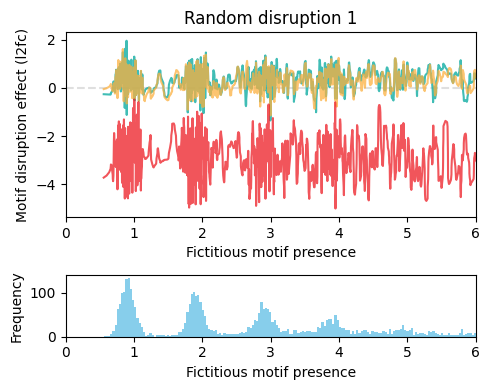

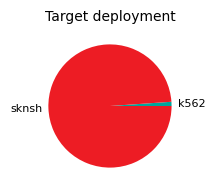

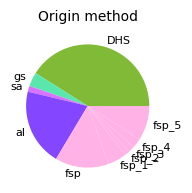

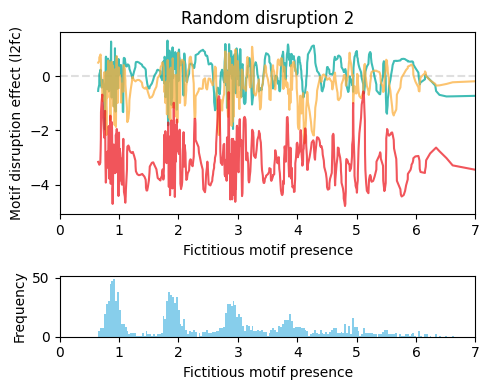

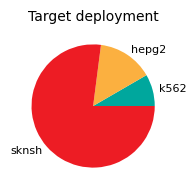

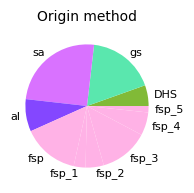

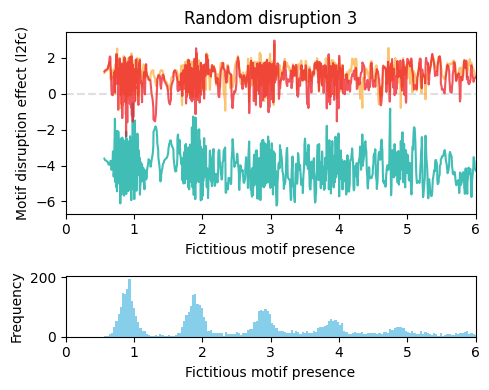

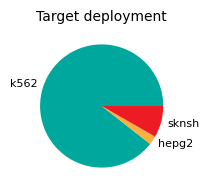

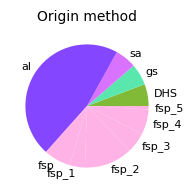

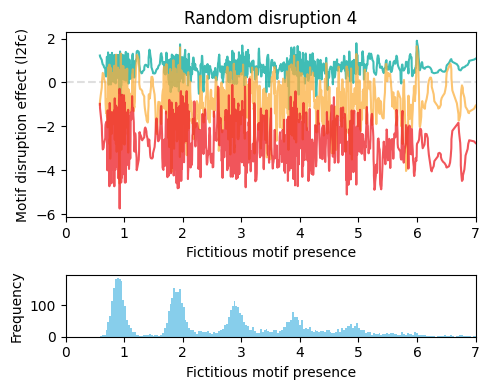

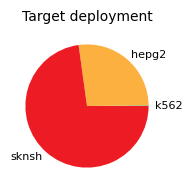

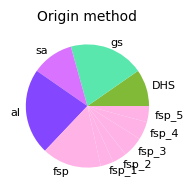

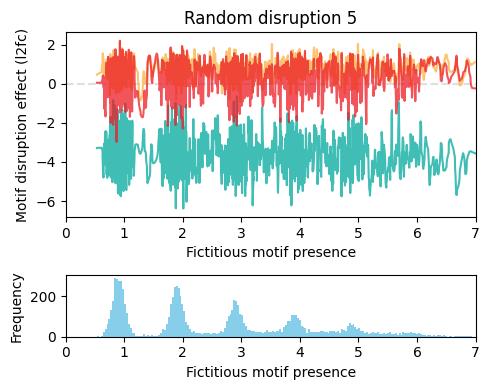

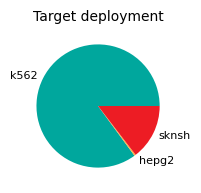

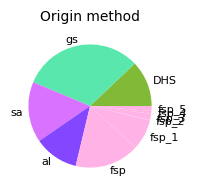

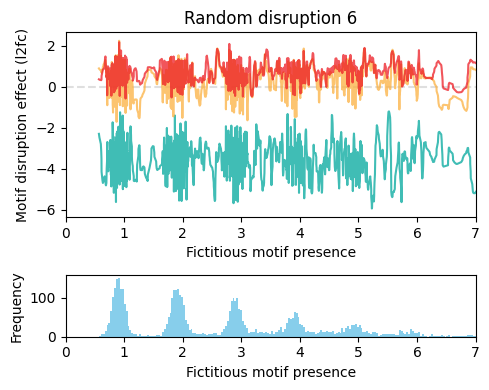

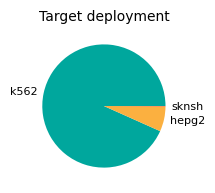

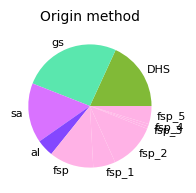

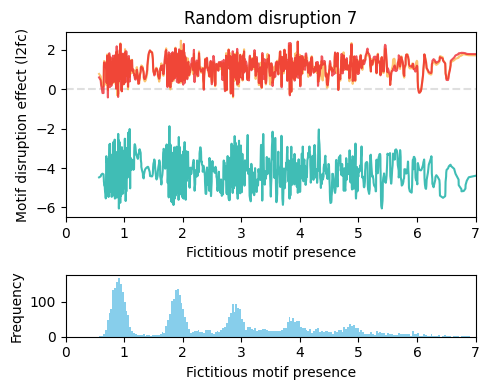

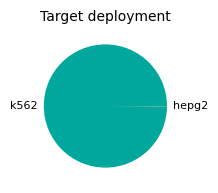

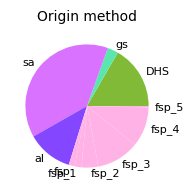

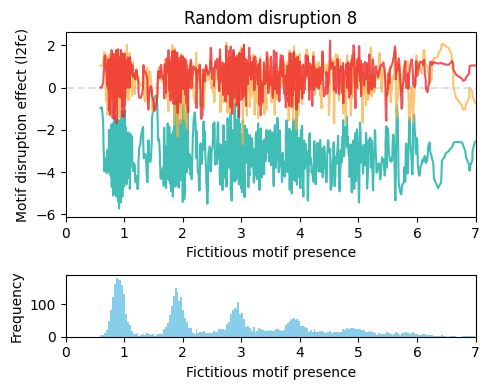

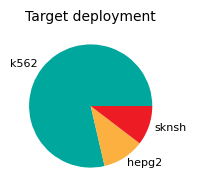

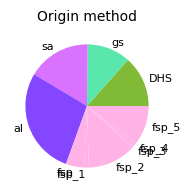

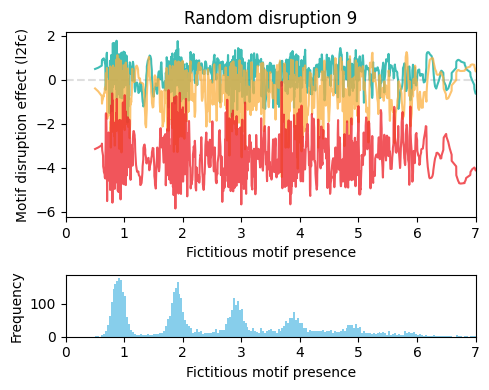

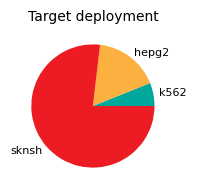

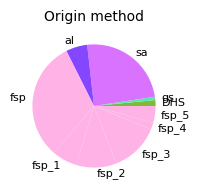

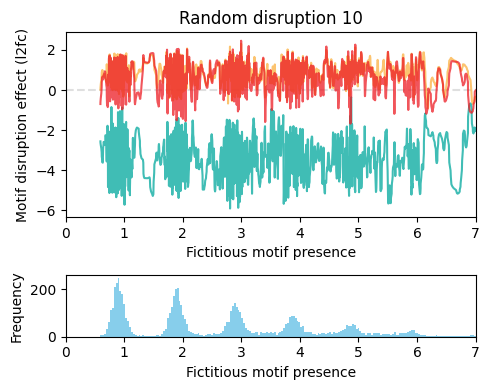

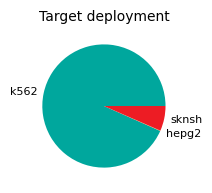

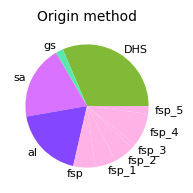

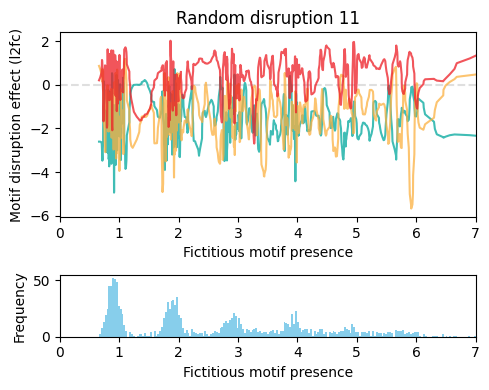

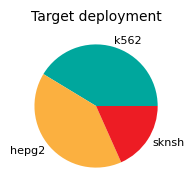

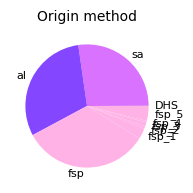

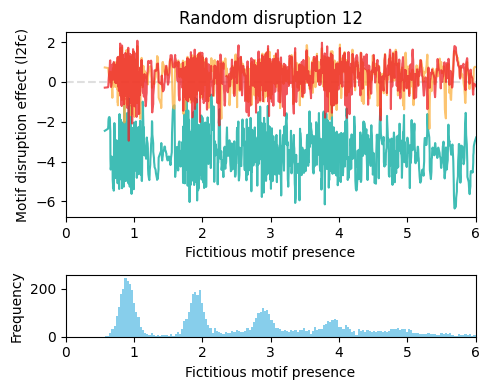

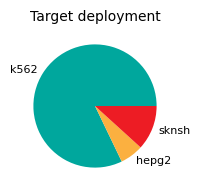

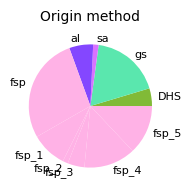

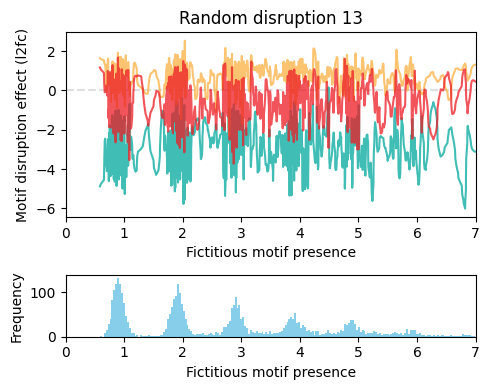

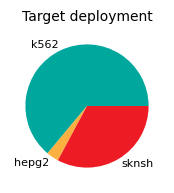

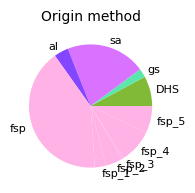

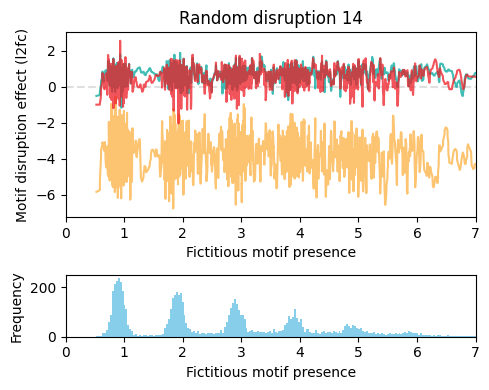

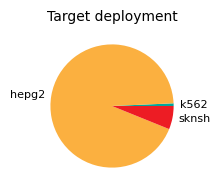

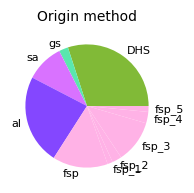

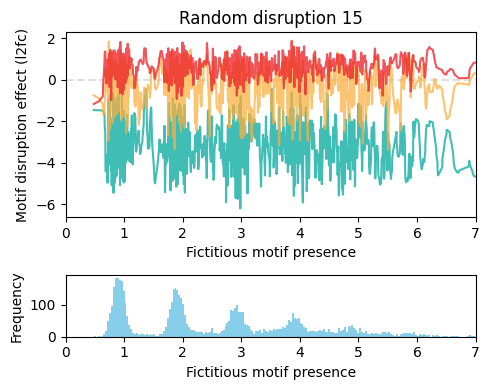

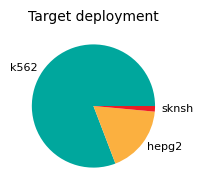

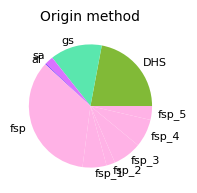

In [ ]:
num_random_attempts = 15
num_disruptions = 5

for random_disruption in range(num_random_attempts):
    coda_library_df_copy = coda_library_df.copy()
    cell_sampling_weights = np.random.dirichlet(np.ones(len(cell_types)), size=1)**2
    cell_sampling_weights = cell_sampling_weights / cell_sampling_weights.sum()
    for cell_idx, cell_type in enumerate(cell_types):
        cell_filter = (coda_library_df_copy['target_cell'] == cell_type.lower())
        coda_library_df_copy.loc[cell_filter, 'cell_sampling_weight'] = cell_sampling_weights[:, cell_idx].item()

    method_sampling_weights = np.random.dirichlet(np.ones(len(method_order)), size=1)
    for method_idx, method_round in enumerate(method_order):
        method_filter = (coda_library_df_copy['method_round'] == method_round)
        coda_library_df_copy.loc[method_filter, 'method_sampling_weight'] = method_sampling_weights[:, method_idx].item()
    coda_library_df_copy['sampling_weight'] = coda_library_df_copy['method_sampling_weight'] * coda_library_df_copy['cell_sampling_weight']
    coda_library_df_copy['sampling_weight'] = coda_library_df_copy['sampling_weight'] / coda_library_df_copy['sampling_weight'].sum()

    num_seqs = np.random.randint(500, 10000)
    sampled_df = coda_library_df_copy.sample(n=num_seqs, weights='sampling_weight')#.reset_index(drop=True)

    motif_seq_idxs = sorted(sampled_df.index)
    block_length = np.random.randint(8, 15)
    motif_seq_positions = []
    for seq_idx in range(len(motif_seq_idxs)):
        #num_blocks = np.random.randint(1, 8)
        num_blocks = random.choices(range(1,8), weights=np.flip(np.arange(1,8) / np.arange(1,8).sum()), k=1)[0]
        block_coverage = []
        for block_j in range(num_blocks):
            block_start = np.random.randint(0, 200 - block_length)
            block_stop = block_start + block_length
            block_coverage.append(np.arange(block_start, block_stop))
        motif_seq_positions.append(np.unique(np.concatenate(block_coverage)))
    motif_presences = [len(motif_seq_position)/block_length + 0.1*(np.random.randn(1).item() - 1) for motif_seq_position in motif_seq_positions]

    motif_disrupted_preds = []
    for n in range(num_disruptions):
        #print(f'Disruption {n + 1}/{num_disruptions}...')
        motif_disrupted_seqs = []
        for seq_idx, seq_positions in zip(motif_seq_idxs, motif_seq_positions):
            motif_disrupted_seq = seq_onehots[seq_idx, ...]
            random_tokens = torch.randint(0, 4, (len(seq_positions),))
            random_onehot = torch.zeros(4, len(seq_positions))
            random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
            motif_disrupted_seq[..., seq_positions] = random_onehot
            motif_disrupted_seqs.append(motif_disrupted_seq)
        motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

        #print(f'Prediction {n + 1}/{num_disruptions}...')
        onehots = motif_disrupted_seqs.clone()
        #--- Predict ----
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
        pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
                onehots,
                right_flank.repeat(onehots.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=-1)
        temp_dataset = TensorDataset(in_tensor)
        temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
        preds = []
        for local_batch in temp_dataloader:
            preds.append(model(local_batch[0].cuda()).detach().cpu())
        #---
        preds = torch.cat(preds, dim=0)
        motif_disrupted_preds.append(preds)

    motif_disrupted_preds = torch.stack(motif_disrupted_preds, dim=0).mean(dim=0)
    motif_original_preds = original_preds[motif_seq_idxs, ...]
    motif_disruption_skews = motif_disrupted_preds - motif_original_preds

    sorting = np.argsort(motif_presences)
    sorted_presences = np.sort(motif_presences)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'height_ratios': [3, 1]})
    xtick_positions = np.arange(0, np.ceil(max(sorted_presences)))
    for i in range(3):
        y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=3)
        ax1.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
        #ax1.scatter(sorted_presences, motif_disruption_skews[sorting, i].numpy(), color=cell_colors[i], alpha=0.25, marker='.', s=5)
        #ax1 = sns.kdeplot(x=sorted_presences, y=motif_disruption_skews[sorting, i].numpy(), color=cell_colors[i], fill=False, alpha=0.5, ax=ax1)
    ax1.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
    ax1.set_xlabel('Fictitious motif presence')
    ax1.set_ylabel('Motif disruption effect (l2fc)')
    ax1.set_title(f'Random disruption {random_disruption + 1}')
    hist, bin_edges, _ = ax2.hist(sorted_presences, bins=200, color='skyblue', alpha=1)
    ax2.set_xlabel('Fictitious motif presence')
    ax2.set_ylabel('Frequency')
    ax1.set_xlim(0, 1)
    ax2.set_xlim(0, 1)
    ax1.set_xticks(xtick_positions)
    ax2.set_xticks(xtick_positions)
    plt.tight_layout()
    plt.show()
    print()

    #motif_hit_df = coda_library_df.iloc[motif_seq_idxs].reset_index(drop=True)

    plot_df = pd.DataFrame(sampled_df['target_cell'].value_counts())
    plot_df = plot_df.reindex(cell_order)

    plot_df_2 = pd.DataFrame(sampled_df['method_round'].value_counts())
    plot_df_2 = plot_df_2.reindex(method_order)

    plot_df.plot(kind='pie', y='target_cell', figsize=(2,2), legend=False, colors=cell_colors, fontsize=8)
    plt.ylabel('')
    plt.title('Target deployment', fontsize=10)
    plt.show()

    plot_df_2.plot(kind='pie', y='method_round', figsize=(2,2), legend=False, colors=method_colors, fontsize=8)
    plt.ylabel('')
    plt.title('Origin method', fontsize=10)
    plt.show()

    print()
    print()
    print()

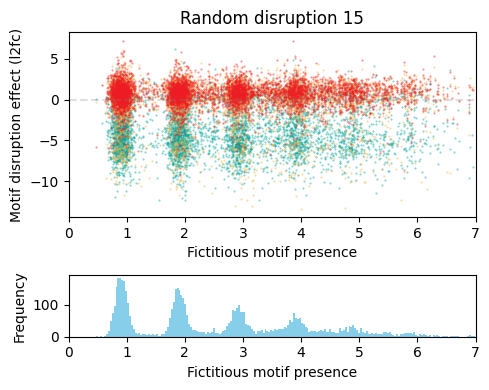

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'height_ratios': [3, 1]})
xtick_positions = np.arange(0, np.ceil(max(sorted_presences)))
for i in range(3):
    # y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=3)
    # ax1.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.5, zorder=0)
    ax1.scatter(sorted_presences, motif_disruption_skews[sorting, i].numpy(), color=cell_colors[i], alpha=0.5, marker='.', s=1, zorder=0)
ax1.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
ax1.set_xlabel('Fictitious motif presence')
ax1.set_ylabel('Motif disruption effect (l2fc)')
ax1.set_title(f'Random disruption {random_disruption + 1}')
hist, bin_edges, _ = ax2.hist(sorted_presences, bins=200, color='skyblue', alpha=1)
ax2.set_xlabel('Fictitious motif presence')
ax2.set_ylabel('Frequency')
ax1.set_xlim(0, 1)
ax2.set_xlim(0, 1)
ax1.set_xticks(xtick_positions)
ax2.set_xticks(xtick_positions)
plt.tight_layout()
plt.show()

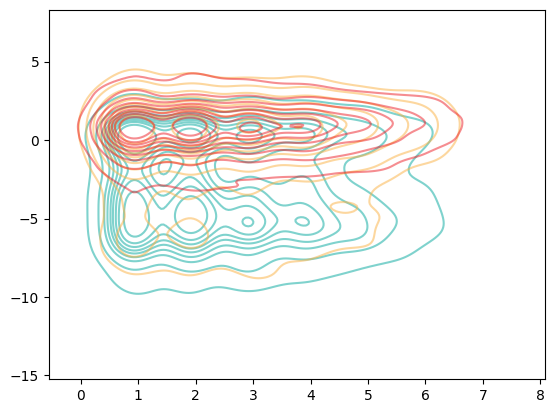

In [ ]:
for i in range(3):
    sns.kdeplot(x=sorted_presences, y=motif_disruption_skews[sorting, i].numpy(), color=cell_colors[i], fill=False, alpha=0.5)
plt.show()

# Exploring CODA elements in OL50

In [ ]:
rootdir = '/content/drive/MyDrive/data/OL50_SatMut/results'

df_dict = {}
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".out"):
            if ('Counts' not in filepath) and ('emVAR' not in filepath):
                file_begin_idx = filepath.find('results/OL') + len('results/OL') - 2
                file_name = filepath[file_begin_idx:]
                print(file_name)
                library_num_end_idx = file_name.find('_')
                library_num = file_name[2:library_num_end_idx]
                remaining_str = file_name[library_num_end_idx+1:]
                cell_name_end_idx = remaining_str.find('_')
                cell_name = remaining_str[:cell_name_end_idx]
                df_name = library_num + "_" + cell_name
                df_temp = pd.read_csv(filepath, sep="	", low_memory=False)
                df_temp['OL'] = library_num
                df_temp['celltype'] = cell_name.lower()
                df_dict[df_name] = df_temp

fasta_file_name = '/content/drive/MyDrive/data/OL50_SatMut/OL50.uncollapsed.fa'

fasta_dict = {}
with open(fasta_file_name, 'r') as f:
    for line in f:
        line_str = str(line)
        if line_str[0] == '>':
            my_id = line_str.lstrip('>').rstrip('\n')
            fasta_dict[my_id] = ''
        else:
            fasta_dict[my_id] += line_str.rstrip('\n')

OL50_HepG2_20230216.out
OL50_K562_20230216.out


In [ ]:
cell_type = 'HepG2' #K562 HepG2
cell_df = df_dict[f'50_{cell_type}']

projects = ['BODA_Sat'] #'UKBB-GTEx_Sat' 'BODA_Sat'

genomic_df = cell_df[cell_df['project'].isin(projects)].sort_values('sat_ref').reset_index(drop=True)
genomic_df[genomic_df['sat_mut'] == 'm0']['log2FoldChange'].isna().sum()

parent_ids = genomic_df[genomic_df['sat_mut'] == 'm0']['ID'].tolist()
parent_seqs = [fasta_dict[x] for x in parent_ids]

parent_ids = genomic_df['sat_ref'].unique()

In [ ]:
for count, parent_id in enumerate(parent_ids):
    print(f'{count} | {parent_id}')

    #--- Use traditional skews
    family_df = genomic_df[genomic_df['sat_ref'] == parent_id].reset_index(drop=True)

    ref_df = family_df[family_df['sat_mut'] == 'm0'].reset_index(drop=True)
    alt_df = family_df[(family_df['sat_mut'] != 'm0') & (~family_df['sat_mut'].str.contains(':'))].reset_index(drop=True)
    alt_df = alt_df[alt_df['log2FoldChange'].notnull()].reset_index(drop=True)

    ref_sequence = fasta_dict[f'{parent_id}']
    ref_lfc = ref_df['log2FoldChange'].item()
    ref_lfcSE = ref_df['lfcSE'].item()

    median = np.median(alt_df['log2FoldChange'], keepdims=False)

    alphabet_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    alt_array = np.zeros((4, len(ref_sequence)))
    lfcSE_array = np.zeros((4, len(ref_sequence)))
    for i in range(len(alt_df)):
        single_alt_df = alt_df.iloc[i]
        pos_id = single_alt_df['sat_mut']
        pos_lfc = single_alt_df['log2FoldChange'].item()
        pos_lfcSE = single_alt_df['lfcSE'].item()
        #pos_skew = pos_lfc - ref_lfc
        pos_skew = pos_lfc - median
        pos_id = pos_id.lstrip('m')
        ref_nt, alt_nt = pos_id[0], pos_id[-1]
        pos = int(pos_id.lstrip(ref_nt).rstrip(alt_nt)) - 1
        alt_array[alphabet_dict[alt_nt], pos] = pos_skew
        lfcSE_array[alphabet_dict[alt_nt], pos] = pos_lfcSE
    #-----

    ref_sequence_str = ref_sequence
    effect_array     = alt_array
    lfcSE_array      = None #lfcSE_array
    ref_lfcSE        = None
    colors           = ['g', 'b', 'C1', 'r'] #['green','blue','orange','red']
    figsize          = (50,5),
    marker_alpha     = 0.2
    stem_alpha       = 0.2
    linestyle        = 'dashed'


    markerfmts = [color + 'o' for color in colors]
    locs = np.arange(0, effect_array.shape[1])
    fig, ax = plt.subplots(figsize=(50,5))

    offset = 0.5
    for i in range(4):
        heads = np.array(effect_array[i,:], copy=True)
        heads[heads == 0.] = np.nan
        markerline, stemlines, baseline = ax.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
        plt.setp(stemlines, 'linestyle', linestyle)
        plt.setp(stemlines, 'alpha', stem_alpha)
        plt.setp(markerline, 'alpha', marker_alpha)
        #plt.setp(baseline, 'color', 'k')
        plt.setp(baseline, 'alpha', 0.2)
        plt.setp(baseline, 'linestyle', 'dashed')
        #offset += 0.1

    plt.margins(x=0.0075)

    effect_means = - effect_array.sum(axis=0) / 3.0

    if lfcSE_array is not None:
        alphas = np.minimum(np.max(lfcSE_array, axis=0), 1.0) ** 2
        shade_color_col='color'
        shade_alpha_col='shade'
    else:
        alphas = np.empty(effect_means.shape[0])
        alphas[:] = np.nan
        shade_color_col=None
        shade_alpha_col=None

    temp_data = [list(ref_sequence_str), effect_means, alphas]
    temp_df = pd.DataFrame(temp_data).transpose()
    temp_df.columns = ['letter', 'height', 'shade']

    temp_df['color'] = temp_df.apply(lambda x: colors[alphabet_dict[x['letter']]], axis=1)
    temp_df['site'] = temp_df.index

    min_limit = 1
    y_max = max(min_limit, max(effect_array.max(), effect_means.max()) + 0.1) + 0.5
    y_min = min(-min_limit, min(effect_array.min(), effect_means.min()) - 0.1) - 0.5

    #--- Plot logo
    fig, ax = dmslogo.draw_logo(data=temp_df,
                            x_col='site',
                            letter_col='letter',
                            letter_height_col='height',
                            color_col='color',
                            shade_color_col=shade_color_col,
                            shade_alpha_col=shade_alpha_col,
                            hide_axis=False,
                            fixed_ymax=y_max,
                            fixed_ymin=y_min,
                            ax=ax)

    plt.xticks(np.arange(4, 199, 5)+0.5, labels=np.arange(4, 199, 5)+1, fontsize=18)
    plt.xlabel('')
    ax.axes.get_yaxis().set_visible(True)
    fig.set_facecolor('white')
    #plt.ylim(-5,6)
    plt.ylabel('Effect')
    plt.yticks(fontsize=18)
    plt.title(f'{parent_id}  {cell_type}', fontsize=32)
    # fig_path = f'/content/drive/MyDrive/figures/OL50_saturation_mutagenesis/logos/' + f'{parent_id}_{cell_type}' + '.png'
    # fig_path = f'/content/drive/MyDrive/figures/OL50_saturation_mutagenesis/block_calls_posterior_v3/' + f'{parent_id}_{cell_type}' + '.png'
    # plt.savefig(fig_path, bbox_inches='tight', dpi=150) #, transparent=True)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cell_type = 'K562' #K562 HepG2
cell_df = df_dict[f'50_{cell_type}']

projects = ['BODA_Sat'] #'UKBB-GTEx_Sat' 'BODA_Sat'

genomic_df = cell_df[cell_df['project'].isin(projects)].sort_values('sat_ref').reset_index(drop=True)
genomic_df[genomic_df['sat_mut'] == 'm0']['log2FoldChange'].isna().sum()

parent_ids = genomic_df[genomic_df['sat_mut'] == 'm0']['ID'].tolist()
parent_seqs = [fasta_dict[x] for x in parent_ids]

parent_ids = genomic_df['sat_ref'].unique()

In [ ]:
for count, parent_id in enumerate(parent_ids):
    print(f'{count} | {parent_id}')

    #--- Use traditional skews
    family_df = genomic_df[genomic_df['sat_ref'] == parent_id].reset_index(drop=True)

    ref_df = family_df[family_df['sat_mut'] == 'm0'].reset_index(drop=True)
    alt_df = family_df[(family_df['sat_mut'] != 'm0') & (~family_df['sat_mut'].str.contains(':'))].reset_index(drop=True)
    alt_df = alt_df[alt_df['log2FoldChange'].notnull()].reset_index(drop=True)

    ref_sequence = fasta_dict[f'{parent_id}']
    ref_lfc = ref_df['log2FoldChange'].item()
    ref_lfcSE = ref_df['lfcSE'].item()

    median = np.median(alt_df['log2FoldChange'], keepdims=False)

    alphabet_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    alt_array = np.zeros((4, len(ref_sequence)))
    lfcSE_array = np.zeros((4, len(ref_sequence)))
    for i in range(len(alt_df)):
        single_alt_df = alt_df.iloc[i]
        pos_id = single_alt_df['sat_mut']
        pos_lfc = single_alt_df['log2FoldChange'].item()
        pos_lfcSE = single_alt_df['lfcSE'].item()
        #pos_skew = pos_lfc - ref_lfc
        pos_skew = pos_lfc - median
        pos_id = pos_id.lstrip('m')
        ref_nt, alt_nt = pos_id[0], pos_id[-1]
        pos = int(pos_id.lstrip(ref_nt).rstrip(alt_nt)) - 1
        alt_array[alphabet_dict[alt_nt], pos] = pos_skew
        lfcSE_array[alphabet_dict[alt_nt], pos] = pos_lfcSE
    #-----

    ref_sequence_str = ref_sequence
    effect_array     = alt_array
    lfcSE_array      = None #lfcSE_array
    ref_lfcSE        = None
    colors           = ['g', 'b', 'C1', 'r'] #['green','blue','orange','red']
    figsize          = (50,5),
    marker_alpha     = 0.2
    stem_alpha       = 0.2
    linestyle        = 'dashed'


    markerfmts = [color + 'o' for color in colors]
    locs = np.arange(0, effect_array.shape[1])
    fig, ax = plt.subplots(figsize=(50,5))

    offset = 0.5
    for i in range(4):
        heads = np.array(effect_array[i,:], copy=True)
        heads[heads == 0.] = np.nan
        markerline, stemlines, baseline = ax.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
        plt.setp(stemlines, 'linestyle', linestyle)
        plt.setp(stemlines, 'alpha', stem_alpha)
        plt.setp(markerline, 'alpha', marker_alpha)
        #plt.setp(baseline, 'color', 'k')
        plt.setp(baseline, 'alpha', 0.2)
        plt.setp(baseline, 'linestyle', 'dashed')
        #offset += 0.1

    plt.margins(x=0.0075)

    effect_means = - effect_array.sum(axis=0) / 3.0

    if lfcSE_array is not None:
        alphas = np.minimum(np.max(lfcSE_array, axis=0), 1.0) ** 2
        shade_color_col='color'
        shade_alpha_col='shade'
    else:
        alphas = np.empty(effect_means.shape[0])
        alphas[:] = np.nan
        shade_color_col=None
        shade_alpha_col=None

    temp_data = [list(ref_sequence_str), effect_means, alphas]
    temp_df = pd.DataFrame(temp_data).transpose()
    temp_df.columns = ['letter', 'height', 'shade']

    temp_df['color'] = temp_df.apply(lambda x: colors[alphabet_dict[x['letter']]], axis=1)
    temp_df['site'] = temp_df.index

    min_limit = 1
    y_max = max(min_limit, max(effect_array.max(), effect_means.max()) + 0.1) + 0.5
    y_min = min(-min_limit, min(effect_array.min(), effect_means.min()) - 0.1) - 0.5

    #--- Plot logo
    fig, ax = dmslogo.draw_logo(data=temp_df,
                            x_col='site',
                            letter_col='letter',
                            letter_height_col='height',
                            color_col='color',
                            shade_color_col=shade_color_col,
                            shade_alpha_col=shade_alpha_col,
                            hide_axis=False,
                            fixed_ymax=y_max,
                            fixed_ymin=y_min,
                            ax=ax)

    plt.xticks(np.arange(4, 199, 5)+0.5, labels=np.arange(4, 199, 5)+1, fontsize=18)
    plt.xlabel('')
    ax.axes.get_yaxis().set_visible(True)
    fig.set_facecolor('white')
    #plt.ylim(-5,6)
    plt.ylabel('Effect')
    plt.yticks(fontsize=18)
    plt.title(f'{parent_id}  {cell_type}', fontsize=32)
    # fig_path = f'/content/drive/MyDrive/figures/OL50_saturation_mutagenesis/logos/' + f'{parent_id}_{cell_type}' + '.png'
    # fig_path = f'/content/drive/MyDrive/figures/OL50_saturation_mutagenesis/block_calls_posterior_v3/' + f'{parent_id}_{cell_type}' + '.png'
    # plt.savefig(fig_path, bbox_inches='tight', dpi=150) #, transparent=True)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
seq_ids = [
       '20211206_221956__59439361__2140::al__k562__0',
       '20211206_24503__33072627__1223::al__hepg2__0',
       '20211206_24503__33072627__1816::al__hepg2__0',
       '20211207_100944__255626__132::sa__hepg2__0',
       '20211207_205407__862697__385::sa__k562__0',
       '20211207_63610__124703__1517::sa__hepg2__0',
       '20211212_45907__313665__1548::fsp__hepg2__5',
       '20211212_45907__313665__213::fsp__hepg2__0',
       '20211212_61436__944763__262::fsp__hepg2__0',
       '20211212_85225__619474__1260::fsp__k562__4',
       '20211212_85225__619474__1680::fsp__k562__5',
       '20211212_85225__619474__194::fsp__k562__0',
       '20211212_92818__893131__1479::fsp__k562__4',]

intersection_threshold = 200
cmap = plt.get_cmap('rainbow', len(motif_ids))

color_dict = dict(zip(2 * motif_ids, 2*[cmap(i) for i in range(len(motif_ids))]))

for order_idx, seq_id in enumerate(seq_ids):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    seq_scan_df = fimo_df[fimo_df['sequence_name'] == seq_id]
    seq_scan_df = seq_scan_df.sort_values('p-value', ascending=True).reset_index(drop=False)

    seq_contributions = all_contributions[:, seq_idx, ...]
    y_max = seq_contributions.max()

    find_motif_names  = []
    motifs_start_ends = []
    orientations      = []
    cover_set         = set()
    num_hits = len(seq_scan_df)
    for i in range(num_hits):
        hit_row = seq_scan_df.iloc[i]
        m_start, m_end = hit_row['start'], hit_row['stop']
        motif_range = set(np.arange(m_start, m_end))
        motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
        pos_contribution = motif_contributions.max()
        neg_contribution = motif_contributions.min()
        contribution_condition = True #(pos_contribution > 0.06) or (neg_contribution < -0.02)
        if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
            find_motif_names.append(hit_row['motif_id'])
            motifs_start_ends.append((m_start, m_end))
            orientations.append(hit_row['strand'])
            cover_set = cover_set | motif_range
    find_motif_short_names = [name + ' ' + strand for name, strand in zip(find_motif_names, orientations)]

    for i in range(0,3):
        matrix_plot = seq_contributions[i, ...]
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            heightscale=1.3, fontaspect=0.55)
        # for idx, motif_name in enumerate(find_motif_names):
        #     try:
        #         color = color_dict[motif_name]
        #     except:
        #         color = color_dict[f'{motif_name}b']
        #     plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        #     plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        #     plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        #     plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

        #     text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
        #     x = motifs_start_ends[idx][0]
        #     y = contrib_min_maxs[idx][1] + 0.05
        #     plt.text(x, y, text, fontsize=16, rotation=90)
        plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
seq_ids = [
       '20211206_221956__59439361__2140::al__k562__0',
       '20211206_24503__33072627__1223::al__hepg2__0',
       '20211206_24503__33072627__1816::al__hepg2__0',
       '20211207_100944__255626__132::sa__hepg2__0',
       '20211207_205407__862697__385::sa__k562__0',
       '20211207_63610__124703__1517::sa__hepg2__0',
       '20211212_45907__313665__1548::fsp__hepg2__5',
       '20211212_45907__313665__213::fsp__hepg2__0',
       '20211212_61436__944763__262::fsp__hepg2__0',
       '20211212_85225__619474__1260::fsp__k562__4',
       '20211212_85225__619474__1680::fsp__k562__5',
       '20211212_85225__619474__194::fsp__k562__0',
       '20211212_92818__893131__1479::fsp__k562__4',]

intersection_threshold = 200
cmap = plt.get_cmap('rainbow', len(motif_ids))

color_dict = dict(zip(2 * motif_ids, 2*[cmap(i) for i in range(len(motif_ids))]))

for order_idx, seq_id in enumerate(seq_ids):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    seq_scan_df = fimo_df[fimo_df['sequence_name'] == seq_id]
    seq_scan_df = seq_scan_df.sort_values('p-value', ascending=True).reset_index(drop=False)

    seq_contributions = all_contributions[:, seq_idx, ...]
    y_max = seq_contributions.max()

    find_motif_names  = []
    motifs_start_ends = []
    orientations      = []
    cover_set         = set()
    num_hits = len(seq_scan_df)
    for i in range(num_hits):
        hit_row = seq_scan_df.iloc[i]
        m_start, m_end = hit_row['start'], hit_row['stop']
        motif_range = set(np.arange(m_start, m_end))
        motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
        pos_contribution = motif_contributions.max()
        neg_contribution = motif_contributions.min()
        contribution_condition = True #(pos_contribution > 0.06) or (neg_contribution < -0.02)
        if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
            find_motif_names.append(hit_row['motif_id'])
            motifs_start_ends.append((m_start, m_end))
            orientations.append(hit_row['strand'])
            cover_set = cover_set | motif_range
    find_motif_short_names = [name + ' ' + strand for name, strand in zip(find_motif_names, orientations)]

    for i in range(0,3):
        matrix_plot = seq_contributions[i, ...]
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            heightscale=1.3, fontaspect=0.55)
        for idx, motif_name in enumerate(find_motif_names):
            try:
                color = color_dict[motif_name]
            except:
                color = color_dict[f'{motif_name}b']
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
            x = motifs_start_ends[idx][0]
            y = contrib_min_maxs[idx][1] + 0.05
            plt.text(x, y, text, fontsize=16, rotation=90)
        plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

# In silico SatMut

In [ ]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')

id_to_onehot_dict = dict(zip(onehots_dict['IDs'], onehots_dict['onehots']))
vocab = constants.STANDARD_NT.copy()

left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)

alphabet_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

In [ ]:
seq_id = '20211212_92818__893131__1479::fsp__k562__4'

seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
seq_idx = seq_df.index.item()

k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

ref_sequence = seq_df['sequence'].item()
seq_onehot = id_to_onehot_dict[seq_id]

tensor_coords = []
alt_onehots = []
for position in range(seq_onehot.shape[-1]):
    for alt_idx in torch.where(seq_onehot[:, position] == 0)[0].tolist():
        alt_onehot = seq_onehot.clone()
        alt_column = torch.zeros(4)
        alt_column[alt_idx] = 1
        alt_onehot[:, position] = alt_column
        tensor_coords.append((position, alt_idx))
        alt_onehots.append(alt_onehot)
alt_onehots = torch.stack(alt_onehots)

pieces = [left_flank.repeat(alt_onehots.shape[0], 1, 1),
        alt_onehots,
        right_flank.repeat(alt_onehots.shape[0], 1, 1)]
in_tensor = torch.cat( pieces, axis=-1)

seq_preds = model(in_tensor.cuda()).detach().cpu()


median = torch.median(seq_preds[:, cell_idx])

alt_array = np.zeros(seq_onehot.shape).T
for idx, tensor_coord in enumerate(tensor_coords):
    alt_array[tensor_coord] = seq_preds[idx, cell_idx] - median
alt_array = alt_array.T

20211212_92818__893131__1479::fsp__k562__4  |  K562 l2FC = 6.26,  HepG2 l2FC = 0.1,  SKNSH l2FC = 0.0


In [ ]:
cell_idx = 0

seq_ids = [
    '20211206_221956__59439361__2140::al__k562__0',
    '20211206_24503__33072627__1223::al__hepg2__0',
    '20211206_24503__33072627__1816::al__hepg2__0',
    '20211207_100944__255626__132::sa__hepg2__0',
    '20211207_205407__862697__385::sa__k562__0',
    '20211207_63610__124703__1517::sa__hepg2__0',
    '20211212_45907__313665__1548::fsp__hepg2__5',
    '20211212_45907__313665__213::fsp__hepg2__0',
    '20211212_61436__944763__262::fsp__hepg2__0',
    '20211212_85225__619474__1260::fsp__k562__4',
    '20211212_85225__619474__1680::fsp__k562__5',
    '20211212_85225__619474__194::fsp__k562__0',
    '20211212_92818__893131__1479::fsp__k562__4',]

for order_idx, seq_id in enumerate(seq_ids):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    ref_sequence = seq_df['sequence'].item()
    seq_onehot = id_to_onehot_dict[seq_id]

    tensor_coords = []
    alt_onehots = []
    for position in range(seq_onehot.shape[-1]):
        for alt_idx in torch.where(seq_onehot[:, position] == 0)[0].tolist():
            alt_onehot = seq_onehot.clone()
            alt_column = torch.zeros(4)
            alt_column[alt_idx] = 1
            alt_onehot[:, position] = alt_column
            tensor_coords.append((position, alt_idx))
            alt_onehots.append(alt_onehot)
    alt_onehots = torch.stack(alt_onehots)

    pieces = [left_flank.repeat(alt_onehots.shape[0], 1, 1),
            alt_onehots,
            right_flank.repeat(alt_onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)

    seq_preds = model(in_tensor.cuda()).detach().cpu()


    median = torch.median(seq_preds[:, cell_idx])

    alt_array = np.zeros(seq_onehot.shape).T
    for idx, tensor_coord in enumerate(tensor_coords):
        alt_array[tensor_coord] = seq_preds[idx, cell_idx] - median
    alt_array = alt_array.T

    ref_sequence_str = ref_sequence
    effect_array     = alt_array
    lfcSE_array      = None #lfcSE_array
    ref_lfcSE        = None
    colors           = ['g', 'b', 'C1', 'r'] #['green','blue','orange','red']
    figsize          = (50,5),
    marker_alpha     = 0.2
    stem_alpha       = 0.2
    linestyle        = 'dashed'


    markerfmts = [color + 'o' for color in colors]
    locs = np.arange(0, effect_array.shape[1])
    fig, ax = plt.subplots(figsize=(50,5))

    offset = 0.5
    for i in range(4):
        heads = np.array(effect_array[i,:], copy=True)
        heads[heads == 0.] = np.nan
        markerline, stemlines, baseline = ax.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
        plt.setp(stemlines, 'linestyle', linestyle)
        plt.setp(stemlines, 'alpha', stem_alpha)
        plt.setp(markerline, 'alpha', marker_alpha)
        #plt.setp(baseline, 'color', 'k')
        plt.setp(baseline, 'alpha', 0.2)
        plt.setp(baseline, 'linestyle', 'dashed')
        #offset += 0.1

    plt.margins(x=0.0075)

    effect_means = - effect_array.sum(axis=0) / 3.0

    if lfcSE_array is not None:
        alphas = np.minimum(np.max(lfcSE_array, axis=0), 1.0) ** 2
        shade_color_col='color'
        shade_alpha_col='shade'
    else:
        alphas = np.empty(effect_means.shape[0])
        alphas[:] = np.nan
        shade_color_col=None
        shade_alpha_col=None

    temp_data = [list(ref_sequence_str), effect_means, alphas]
    temp_df = pd.DataFrame(temp_data).transpose()
    temp_df.columns = ['letter', 'height', 'shade']

    temp_df['color'] = temp_df.apply(lambda x: colors[alphabet_dict[x['letter']]], axis=1)
    temp_df['site'] = temp_df.index

    min_limit = 1
    y_max = max(min_limit, max(effect_array.max(), effect_means.max()) + 0.1) + 0.5
    y_min = min(-min_limit, min(effect_array.min(), effect_means.min()) - 0.1) - 0.5

    #--- Plot logo
    fig, ax = dmslogo.draw_logo(data=temp_df,
                            x_col='site',
                            letter_col='letter',
                            letter_height_col='height',
                            color_col='color',
                            shade_color_col=shade_color_col,
                            shade_alpha_col=shade_alpha_col,
                            hide_axis=False,
                            fixed_ymax=y_max,
                            fixed_ymin=y_min,
                            ax=ax)

    plt.xticks(np.arange(4, 199, 5)+0.5, labels=np.arange(4, 199, 5)+1, fontsize=18)
    plt.xlabel('')
    ax.axes.get_yaxis().set_visible(True)
    fig.set_facecolor('white')
    #plt.ylim(-5,6)
    plt.ylabel('Effect')
    plt.yticks(fontsize=18)
    plt.title(f'{seq_id}  {cell_types[cell_idx]}', fontsize=32)
    # fig_path = f'/content/drive/MyDrive/figures/OL50_saturation_mutagenesis/logos/' + f'{parent_id}_{cell_type}' + '.png'
    # fig_path = f'/content/drive/MyDrive/figures/OL50_saturation_mutagenesis/block_calls_posterior_v3/' + f'{parent_id}_{cell_type}' + '.png'
    # plt.savefig(fig_path, bbox_inches='tight', dpi=150) #, transparent=True)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cell_idx = 1

seq_ids = [
    '20211206_221956__59439361__2140::al__k562__0',
    '20211206_24503__33072627__1223::al__hepg2__0',
    '20211206_24503__33072627__1816::al__hepg2__0',
    '20211207_100944__255626__132::sa__hepg2__0',
    '20211207_205407__862697__385::sa__k562__0',
    '20211207_63610__124703__1517::sa__hepg2__0',
    '20211212_45907__313665__1548::fsp__hepg2__5',
    '20211212_45907__313665__213::fsp__hepg2__0',
    '20211212_61436__944763__262::fsp__hepg2__0',
    '20211212_85225__619474__1260::fsp__k562__4',
    '20211212_85225__619474__1680::fsp__k562__5',
    '20211212_85225__619474__194::fsp__k562__0',
    '20211212_92818__893131__1479::fsp__k562__4',]

for order_idx, seq_id in enumerate(seq_ids):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    ref_sequence = seq_df['sequence'].item()
    seq_onehot = id_to_onehot_dict[seq_id]

    tensor_coords = []
    alt_onehots = []
    for position in range(seq_onehot.shape[-1]):
        for alt_idx in torch.where(seq_onehot[:, position] == 0)[0].tolist():
            alt_onehot = seq_onehot.clone()
            alt_column = torch.zeros(4)
            alt_column[alt_idx] = 1
            alt_onehot[:, position] = alt_column
            tensor_coords.append((position, alt_idx))
            alt_onehots.append(alt_onehot)
    alt_onehots = torch.stack(alt_onehots)

    pieces = [left_flank.repeat(alt_onehots.shape[0], 1, 1),
            alt_onehots,
            right_flank.repeat(alt_onehots.shape[0], 1, 1)]
    in_tensor = torch.cat( pieces, axis=-1)

    seq_preds = model(in_tensor.cuda()).detach().cpu()

    median = torch.median(seq_preds[:, cell_idx])
    #median = model(torch.cat( [left_flank, seq_onehot.unsqueeze(0), right_flank], axis=-1).cuda()).detach().cpu()[:, cell_idx]

    alt_array = np.zeros(seq_onehot.shape).T
    for idx, tensor_coord in enumerate(tensor_coords):
        alt_array[tensor_coord] = seq_preds[idx, cell_idx] - median
    alt_array = alt_array.T

    ref_sequence_str = ref_sequence
    effect_array     = alt_array
    lfcSE_array      = None #lfcSE_array
    ref_lfcSE        = None
    colors           = ['g', 'b', 'C1', 'r'] #['green','blue','orange','red']
    figsize          = (50,5),
    marker_alpha     = 0.2
    stem_alpha       = 0.2
    linestyle        = 'dashed'


    markerfmts = [color + 'o' for color in colors]
    locs = np.arange(0, effect_array.shape[1])
    fig, ax = plt.subplots(figsize=(50,5))

    offset = 0.5
    for i in range(4):
        heads = np.array(effect_array[i,:], copy=True)
        heads[heads == 0.] = np.nan
        markerline, stemlines, baseline = ax.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
        plt.setp(stemlines, 'linestyle', linestyle)
        plt.setp(stemlines, 'alpha', stem_alpha)
        plt.setp(markerline, 'alpha', marker_alpha)
        #plt.setp(baseline, 'color', 'k')
        plt.setp(baseline, 'alpha', 0.2)
        plt.setp(baseline, 'linestyle', 'dashed')
        #offset += 0.1

    plt.margins(x=0.0075)

    effect_means = - effect_array.sum(axis=0) / 3.0

    if lfcSE_array is not None:
        alphas = np.minimum(np.max(lfcSE_array, axis=0), 1.0) ** 2
        shade_color_col='color'
        shade_alpha_col='shade'
    else:
        alphas = np.empty(effect_means.shape[0])
        alphas[:] = np.nan
        shade_color_col=None
        shade_alpha_col=None

    temp_data = [list(ref_sequence_str), effect_means, alphas]
    temp_df = pd.DataFrame(temp_data).transpose()
    temp_df.columns = ['letter', 'height', 'shade']

    temp_df['color'] = temp_df.apply(lambda x: colors[alphabet_dict[x['letter']]], axis=1)
    temp_df['site'] = temp_df.index

    min_limit = 1
    y_max = max(min_limit, max(effect_array.max(), effect_means.max()) + 0.1) + 0.5
    y_min = min(-min_limit, min(effect_array.min(), effect_means.min()) - 0.1) - 0.5

    #--- Plot logo
    fig, ax = dmslogo.draw_logo(data=temp_df,
                            x_col='site',
                            letter_col='letter',
                            letter_height_col='height',
                            color_col='color',
                            shade_color_col=shade_color_col,
                            shade_alpha_col=shade_alpha_col,
                            hide_axis=False,
                            fixed_ymax=y_max,
                            fixed_ymin=y_min,
                            ax=ax)

    plt.xticks(np.arange(4, 199, 5)+0.5, labels=np.arange(4, 199, 5)+1, fontsize=18)
    plt.xlabel('')
    ax.axes.get_yaxis().set_visible(True)
    fig.set_facecolor('white')
    #plt.ylim(-5,6)
    plt.ylabel('Effect')
    plt.yticks(fontsize=18)
    plt.title(f'{seq_id}  {cell_types[cell_idx]}', fontsize=32)
    # fig_path = f'/content/drive/MyDrive/figures/OL50_saturation_mutagenesis/logos/' + f'{parent_id}_{cell_type}' + '.png'
    # fig_path = f'/content/drive/MyDrive/figures/OL50_saturation_mutagenesis/block_calls_posterior_v3/' + f'{parent_id}_{cell_type}' + '.png'
    # plt.savefig(fig_path, bbox_inches='tight', dpi=150) #, transparent=True)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.